## Dataset Class


In [3]:
import os
import os.path as osp

import networkx as nx
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.utils import from_networkx

class MaxIndDataset(InMemoryDataset):
    def __init__(self, root):
        self.label_frame = pd.read_csv(osp.join(root, "label.csv"))
        self.weight_frame = pd.read_csv(osp.join(root, "weight.csv"))
        self.root_dir = root
        self.num_graphs = len(self.label_frame)
        super(MaxIndDataset, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])
   
    @property   
    def processed_file_names(self):
        return ['data.pt']
    
    def _download(self):
        pass
    
    def process(self):
        data_list = []
        for i in range(self.num_graphs):
            graph_name = os.path.join(self.root_dir, self.label_frame.iloc[i, 0])
            graph = nx.read_adjlist(graph_name, nodetype=int)
   
            weight = torch.tensor(self.weight_frame.iloc[i, 1:], dtype=torch.float)
            label = torch.tensor(self.label_frame.iloc[i, 1:], dtype=torch.long)
        
            data = from_networkx(graph)
            data.x = weight
            data.y = label
            
            data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

## Drawing Utility

Takes in a data entry:
* "edge_list" (list of edges)
* "x" labels (weights)
* "y" lables (output labels)

and draws the graph out in a circular format. 

In [4]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch
def draw_entry(entry, color_map = None):
    g = to_networkx(entry)
    
    if color_map:
        label = color_map
    else:
        label = entry["y"]
    
    # Create color map from selected nodes, green for selected, grey for unselected.
    color_map = ["grey"] * len(g.nodes)

    for i in np.flatnonzero(label):
        color_map[i] = "green"
        
    node_labels = entry["x"]
    
    if not torch.equal(node_labels, torch.ones(len(g.nodes))):
        node_labels = {k: "{0}:\n{1:.3f}".format(k, v) for (k, v) in enumerate(node_labels)}
    else:
        node_labels = {k: k for k in g.nodes}
    
    plt.figure()
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, pos, node_labels)
    plt.show()  

In [5]:
def split_loader(dataset, train_size, test_size, batch_size):
    dataset.shuffle()
    size = len(dataset)
    
    tr_i = int(size * train_size)
    val_i = tr_i + int(size * test_size)
    train_loader = DataLoader(dataset[:tr_i], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset[tr_i: val_i])
    test_loader = DataLoader(dataset[val_i:])
    return train_loader, val_loader, test_loader

In [6]:
visualize = MaxIndDataset('data/weighted_small')

/home/zach/anaconda3/envs/deepkidney/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/zach/anaconda3/envs/deepkidney/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


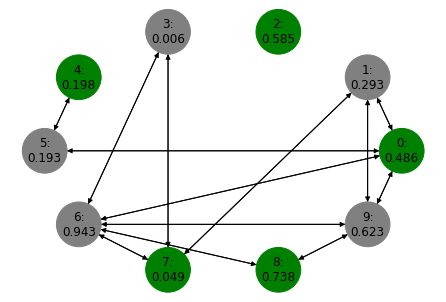

In [7]:
draw_entry(visualize[2])

In [8]:
bin_80 = MaxIndDataset('data/binomial_80')

In [9]:
train_loader, val_loader, test_loader = split_loader(bin_80, .7, .2, 20)

In [10]:

for b in train_loader:
    print(b)
    print(b.x.size())
    print(b.edge_index.size())
    break

Batch(batch=[1600], edge_index=[2, 24804], x=[1600], y=[1600])
torch.Size([1600])
torch.Size([2, 24804])


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class BasicNet(torch.nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        weight = data["x"].view(-1, 1)
        edge_index = data["edge_index"]
        x = self.conv1(weight, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MultiNet(torch.nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
        self.conv_in = GCNConv(1, 32)
        self.conv_mid1 = GCNConv(32, 32)
        self.conv_mid2 = GCNConv(32, 32)
        self.conv_mid3 = GCNConv(32, 32)
        self.conv_mid4 = GCNConv(32, 32)
        self.conv_out = GCNConv(32, 1)

    def forward(self, data):
        weight = data["x"].view(-1, 1)
        edge_index = data["edge_index"]
        x = self.conv_in(weight, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid3(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid4(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_out(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [14]:
from tqdm import tqdm#, tqdm_notebook

### Runs but losses dont go down, seems to converge to around 0.48

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiNet().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(epoch):
    model.train()
    running_loss = 0.0
    for i, item in enumerate(train_loader):
        optimizer.zero_grad()
        item = item.to(device)
        outputs = model(item)
        
        loss = criterion(outputs, item["y"].float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    running_acc = 0.0 # Implement later
    running_loss = 0.0
    for i, item in enumerate(loader):
        item = item.to(device)
        outputs = model(item)
        loss = criterion(outputs.view(-1, 1), item["y"].float().view(-1, 1))
        running_loss += loss.item()
    return running_loss / len(loader)
        
for epoch in tqdm(range(5)):
    train_loss = train(epoch)
    val_loss = evaluate(val_loader)
    print(('Epoch: {:03d}, Train Loss: {:.4f}, Val Loss: {:.3f}').format(epoch, train_loss, val_loss))

print('Finished Training')        

100%|██████████| 5/5 [00:53<00:00, 10.59s/it]


Epoch: 000, Train Loss: 0.5144, Val Loss: 0.504
Epoch: 001, Train Loss: 0.4893, Val Loss: 0.474
Epoch: 002, Train Loss: 0.4644, Val Loss: 0.455
Epoch: 003, Train Loss: 0.4516, Val Loss: 0.449
Epoch: 004, Train Loss: 0.4445, Val Loss: 0.440
Finished Training


In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [28]:
torch.save(model.state_dict(), "model/weighted_multinet_mini.pt")

In [15]:
model.eval()

MultiNet(
  (conv_in): GCNConv(1, 32)
  (conv_mid1): GCNConv(32, 32)
  (conv_mid2): GCNConv(32, 32)
  (conv_mid3): GCNConv(32, 32)
  (conv_mid4): GCNConv(32, 32)
  (conv_out): GCNConv(32, 1)
)

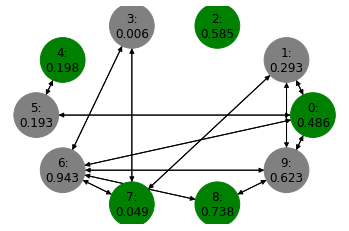

In [33]:
test_item = visualize[2]
draw_entry(test_item)

In [17]:
test_item.to(device)
out = model(test_item)
out

tensor([[0.2546],
        [0.2616],
        [0.1747],
        [0.3437],
        [0.1600],
        [0.1340],
        [0.0401],
        [0.1503],
        [0.4149],
        [0.1322]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [18]:
# Sorts the indices from greatest value to the least
ans = np.flip(out.detach().cpu().numpy().T.argsort())
ans


array([[8, 3, 1, 0, 2, 4, 7, 5, 9, 6]])

In [27]:
import Env
import importlib
importlib.reload(Env)



<module 'Env' from '/home/zach/Documents/summer/DeepKidney/Env.py'>

In [32]:
processed_test_item = {k: np.round(v.cpu().data.numpy(), 3) for k, v in iter(test_item)}
state = Env.MaxSetState(processed_test_item)

while len(state.actions()) > 1 :
    state_item = {}
    state_item["x"] = test_item["x"]
    print(len(state.get_edgelist().transpose()))
    print(state.get_edgelist().transpose())
    state_item["edge_index"] = torch.tensor(state.get_edgelist()).to(device)
    
    probs = model(state_item)
    ranking = np.flip(probs.detach().cpu().numpy().T.argsort())[0]
    print(ranking)
    
    place = 0
    while (place < len(ranking) and state.state[ranking[place]] == 0):
        place += 1
    
    print(place)
    state, reward = state.step(ranking[place])
    print(state)
    print("Reward: " + str(reward))

26
[[0 1]
 [0 5]
 [0 6]
 [0 9]
 [1 0]
 [1 7]
 [1 9]
 [5 0]
 [5 4]
 [6 0]
 [6 3]
 [6 7]
 [6 8]
 [6 9]
 [9 0]
 [9 1]
 [9 6]
 [9 8]
 [7 1]
 [7 3]
 [7 6]
 [3 6]
 [3 7]
 [4 5]
 [8 6]
 [8 9]]
[8 3 1 0 2 4 7 5 9 6]
0
[ True  True  True  True  True  True  True  True False  True]
Reward: 0.738
22
[[0 1]
 [0 5]
 [0 6]
 [0 9]
 [1 0]
 [1 7]
 [1 9]
 [5 0]
 [5 4]
 [6 0]
 [6 3]
 [6 7]
 [6 9]
 [9 0]
 [9 1]
 [9 6]
 [7 1]
 [7 3]
 [7 6]
 [3 6]
 [3 7]
 [4 5]]
[9 3 1 2 8 5 4 0 7 6]
0
[ True  True  True  True  True  True  True  True False False]
Reward: 0.623
16
[[0 1]
 [0 5]
 [0 6]
 [1 0]
 [1 7]
 [5 0]
 [5 4]
 [6 0]
 [6 3]
 [6 7]
 [7 1]
 [7 3]
 [7 6]
 [3 6]
 [3 7]
 [4 5]]
[1 3 6 4 2 9 8 5 0 7]
0
[ True False  True  True  True False  True  True False False]
Reward: 0.293
8
[[0 6]
 [6 0]
 [6 3]
 [6 7]
 [7 3]
 [7 6]
 [3 6]
 [3 7]]
[0 7 3 5 4 1 2 9 8 6]
0
[False False  True  True  True False  True  True False False]
Reward: 0.486
6
[[6 3]
 [6 7]
 [7 3]
 [7 6]
 [3 6]
 [3 7]]
[5 4 1 7 6 3 0 2 9 8]
1
[False False

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)